#Downloading Datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Colab_Notebooks/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d anindya2906/glove6b

100% 840M/844M [00:29<00:00, 31.8MB/s]
100% 844M/844M [00:29<00:00, 29.6MB/s]


In [4]:
!unzip /content/glove6b.zip

Archive:  /content/glove6b.zip
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
  inflating: glove.6B.50d.txt        


In [5]:
!kaggle datasets download -d adityajn105/flickr8k

100% 1.03G/1.04G [00:26<00:00, 40.6MB/s]
100% 1.04G/1.04G [00:26<00:00, 42.7MB/s]


In [6]:
!unzip /content/flickr8k.zip -d /content/flickr

Streaming output truncated to the last 5000 lines.
  inflating: /content/flickr/Images/2844846111_8c1cbfc75d.jpg  
  inflating: /content/flickr/Images/2844963839_ff09cdb81f.jpg  
  inflating: /content/flickr/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/flickr/Images/2845691057_d4ab89d889.jpg  
  inflating: /content/flickr/Images/2845845721_d0bc113ff7.jpg  
  inflating: /content/flickr/Images/2846037553_1a1de50709.jpg  
  inflating: /content/flickr/Images/2846785268_904c5fcf9f.jpg  
  inflating: /content/flickr/Images/2846843520_b0e6211478.jpg  
  inflating: /content/flickr/Images/2847514745_9a35493023.jpg  
  inflating: /content/flickr/Images/2847615962_c330bded6e.jpg  
  inflating: /content/flickr/Images/2847859796_4d9cb0d31f.jpg  
  inflating: /content/flickr/Images/2848266893_9693c66275.jpg  
  inflating: /content/flickr/Images/2848571082_26454cb981.jpg  
  inflating: /content/flickr/Images/2848895544_6d06210e9d.jpg  
  inflating: /content/flickr/Images/2848977044_446a31

# Importing the Necessary Libraries

In [7]:
import os
import pickle
import re
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from math import ceil
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, Bidirectional, Dot, Activation, RepeatVector, Multiply, Lambda
from nltk.translate.bleu_score import corpus_bleu

import warnings
warnings.filterwarnings('ignore')

#Feature Extraction with Xception Model

In [8]:
base_model = Xception(include_top=True, weights='imagenet')
features_extraction_model = Model(inputs = base_model.inputs, outputs = base_model.layers[-2].output)

features_extraction_model.summary()

91884032/91884032 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  

In [9]:
features = {}

image_directory = '/content/flickr/Images'
image_names = os.listdir(image_directory)

def features_extraction(image_directory):
  for image_name in tqdm(image_names):
    image_path = os.path.join(image_directory, image_name)
    image = load_img(image_path, target_size=(299, 299))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    image_feature = features_extraction_model.predict(image, verbose=0)
    image_id = image_name.split('.')[0]
    features[image_id] = image_feature

  return features

image_features= features_extraction(image_directory)

  0%|          | 0/8091 [00:00<?, ?it/s]

In [10]:
image_features_pickle = '/content/flickr/image_features.pkl'

with open(image_features_pickle, 'wb') as f:
    pickle.dump(image_features, f)


with open(image_features_pickle, 'rb') as file:
    image_features = pickle.load(file)

#Creating an Image to Captions Mapping

In [11]:
def create_image_to_captions_mapping(file_path):
    image_to_captions_mapping = {}

    with open(file_path, 'r') as file:
        next(file)
        for line in tqdm(file, desc="Processing captions"):
            tokens = line.strip().split(',')
            if len(tokens) < 2:
                continue
            image_id, *captions = tokens
            image_id = image_id.split('.')[0]
            caption = " ".join(captions)

            if image_id in image_to_captions_mapping:
                image_to_captions_mapping[image_id].append(caption)
            else:
                image_to_captions_mapping[image_id] = [caption]

    return image_to_captions_mapping

captions_file_path = '/content/flickr/captions.txt'

image_to_captions_mapping = create_image_to_captions_mapping(captions_file_path)

total_captions = sum(len(captions) for captions in image_to_captions_mapping.values())
print("Total number of captions:", total_captions)

Processing captions: 0it [00:00, ?it/s]

Total number of captions: 40455


##Caption Cleaning and Preprocessing

In [12]:
def clean_captions(mapping):
    cleaned_mapping = {}
    for image_id, captions in mapping.items():
        cleaned_captions = []
        for caption in captions:
            caption = caption.lower()
            caption = re.sub(r'[^a-zA-Z\s]', '', caption)
            caption = re.sub(r'\s+', ' ', caption).strip()
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            cleaned_captions.append(caption)
        cleaned_mapping[image_id] = cleaned_captions
    return cleaned_mapping

In [13]:
image_to_captions_mapping['1007129816_e794419615']

['A man in an orange hat starring at something .',
 'A man wears an orange hat and glasses .',
 'A man with gauges and glasses is wearing a Blitz hat .',
 'A man with glasses is wearing a beer can crocheted hat .',
 'The man with pierced ears is wearing glasses and an orange hat .']

In [14]:
image_to_captions_mapping = clean_captions(image_to_captions_mapping)

In [15]:
image_to_captions_mapping['1007129816_e794419615']

['startseq man in an orange hat starring at something endseq',
 'startseq man wears an orange hat and glasses endseq',
 'startseq man with gauges and glasses is wearing blitz hat endseq',
 'startseq man with glasses is wearing beer can crocheted hat endseq',
 'startseq the man with pierced ears is wearing glasses and an orange hat endseq']

#Tokenizing and Analyzing Image Captions for Vocabulary Size and Maximum Length

In [16]:
captions = []

for captions_list in image_to_captions_mapping.values():
    for caption in captions_list:
        captions.append(caption)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)

vocab_size = len(tokenizer.word_index) + 1

max_sequence_length = 0
for caption in captions:
    sequence = tokenizer.texts_to_sequences([caption])[0]
    sequence_length = len(sequence)
    if sequence_length > max_sequence_length:
        max_sequence_length = sequence_length

print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_sequence_length)

Vocabulary Size: 8768
Maximum Caption Length: 34


In [17]:
tokenizer_pickle = '/content/flickr/tokenizer.pkl'

with open(tokenizer_pickle, 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

with open(tokenizer_pickle, 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

#Image Captioning Dataset Splitting and Data Generation

In [18]:
image_ids = list(image_to_captions_mapping.keys())

split_index = int(len(image_ids) * 0.90)
training_set = image_ids[:split_index]
testing_set = image_ids[split_index:]

In [19]:
def data_generator(training_set, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    while True:
        image_features, input_sequences, output_sequences = [], [], []

        for image_id in training_set:
            captions = image_to_captions_mapping[image_id]

            for caption in captions:
                caption_seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(caption_seq)):
                    input_seq, output_seq = caption_seq[:i], caption_seq[i]

                    input_seq = pad_sequences([input_seq], maxlen=max_caption_length)[0]
                    output_seq = to_categorical([output_seq], num_classes=vocab_size)[0]

                    image_features.append(features[image_id][0])
                    input_sequences.append(input_seq)
                    output_sequences.append(output_seq)

                    if len(image_features) == batch_size:
                        yield [np.array(image_features), np.array(input_sequences)], np.array(output_sequences)
                        image_features, input_sequences, output_sequences = [], [], []

#Creating an Embedding Layer with Pretrained GloVe Word Vectors

In [20]:
glove_path = '/content/glove.6B.100d.txt'

embedding_matrix = {}

with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_matrix[word] = coefs

embedding_dim = len(list(embedding_matrix.values())[0])

filtered_embedding_matrix = {}

for word, idx in tokenizer.word_index.items():
    if word in embedding_matrix:
        filtered_embedding_matrix[word] = embedding_matrix[word]
    else:
        filtered_embedding_matrix[word] = np.random.rand(embedding_dim)

embedding_weights = np.zeros((vocab_size, embedding_dim))

for word, idx in tokenizer.word_index.items():
    if word in filtered_embedding_matrix:
        embedding_weights[idx] = filtered_embedding_matrix[word]


embedding_layer = Embedding(
    input_dim = vocab_size,
    output_dim = embedding_dim,
    weights = [embedding_weights],
    input_length = max_sequence_length,
    trainable=False
)

#Image Captioning Model Training and Evaluation

##Image Captioning Model with Attention Mechanism

In [21]:
# Encoder for image features
image_input = Input(shape=(2048,))
image_dropout = Dropout(0.5)(image_input)
image_fc = Dense(256, activation='relu')(image_dropout)
image_projected = RepeatVector(max_sequence_length)(image_fc)
image_lstm = Bidirectional(LSTM(256, return_sequences=True))(image_projected)

# Encoder for text sequences
text_input = Input(shape=(max_sequence_length,))
text_embedding = embedding_layer(text_input)
text_dropout = Dropout(0.5)(text_embedding)
text_lstm = Bidirectional(LSTM(256, return_sequences=True))(text_dropout)

# Attention mechanism
attention_layer = tf.keras.layers.Attention()([image_lstm, text_lstm])
attention_context = tf.keras.layers.Dot(axes=[2, 2])([attention_layer, text_lstm])
context_vector = tf.reduce_sum(attention_context, axis=1)

# Decoder
decoder_input = concatenate([context_vector, image_fc], axis=-1)
decoder_dense1 = Dense(256, activation='relu')(decoder_input)
output_layer = Dense(vocab_size, activation='softmax')(decoder_dense1)

# Define the model
captioning_model = Model(inputs=[image_input, text_input], outputs=output_layer)
captioning_model.compile(loss='categorical_crossentropy', optimizer='adam')

# Model summary
captioning_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                                  
 input_3 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  524544    ['dropout[0][0]']             
                                                                                            

##Training the Model

In [22]:
epochs = 50
batch_size = 32

steps_per_epoch = ceil(len(training_set) / batch_size)

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    train_generator = data_generator(training_set, image_to_captions_mapping, image_features, tokenizer, max_sequence_length, vocab_size, batch_size)

    captioning_model.fit(train_generator,
                         epochs=1,
                         steps_per_epoch = steps_per_epoch,
                         verbose=1)

Epoch 1/50
228/228 [==============================] - 16s 20ms/step - loss: 6.1746
Epoch 2/50
228/228 [==============================] - 4s 16ms/step - loss: 4.8952
Epoch 3/50
228/228 [==============================] - 5s 20ms/step - loss: 4.4407
Epoch 4/50
228/228 [==============================] - 4s 18ms/step - loss: 4.0412
Epoch 5/50
228/228 [==============================] - 4s 17ms/step - loss: 3.7106
Epoch 6/50
228/228 [==============================] - 5s 21ms/step - loss: 3.4261
Epoch 7/50
228/228 [==============================] - 4s 17ms/step - loss: 3.1028
Epoch 8/50
228/228 [==============================] - 4s 16ms/step - loss: 2.8332
Epoch 9/50
228/228 [==============================] - 5s 23ms/step - loss: 2.5644
Epoch 10/50
228/228 [==============================] - 4s 17ms/step - loss: 2.3471
Epoch 11/50
228/228 [==============================] - 4s 16ms/step - loss: 2.1833
Epoch 12/50
228/228 [==============================] - 4s 18ms/step - loss: 2.0089
Epoch 13/50


##Generating Image Captions Using Beam Search

In [23]:
def get_word_from_index(index, tokenizer):
    for word, idx in tokenizer.word_index.items():
        if idx == index:
            return word
    return None

In [ ]:
def beam_search_caption(model, image_features, tokenizer, max_caption_length, beam_width=3):
    sequences = [{'caption': 'startseq', 'log_prob': 0.0}]

    for _ in range(max_caption_length):
        all_candidates = []

        for seq in sequences:
            caption = seq['caption']
            log_prob = seq['log_prob']

            if 'endseq' in caption.split():
                all_candidates.append(seq)
                continue

            sequence = tokenizer.texts_to_sequences([caption])[0]
            sequence = pad_sequences([sequence], maxlen=max_caption_length)
            yhat = model.predict([image_features, sequence], verbose=0)

            top_word_indices = np.argsort(yhat[0])[-beam_width:]
            log_probs = np.log(yhat[0][top_word_indices])

            for i in range(beam_width):
                word_index = top_word_indices[i]
                word_log_prob = log_probs[i]

                new_seq = {'caption': caption + ' ' + get_word_from_index(word_index, tokenizer), 'log_prob': log_prob + word_log_prob}
                all_candidates.append(new_seq)

        ordered = sorted(all_candidates, key=lambda x: x['log_prob'], reverse=True)
        sequences = ordered[:beam_width]

    return sequences[0]['caption']

In [ ]:
def generate_caption_with_beam_search(image_path, beam_width=5):
    image = Image.open(image_path)
    image_name = os.path.basename(image_path).split('.')[0]
    image_id = image_name
    captions = image_to_captions_mapping[image_id]

    plt.imshow(image)
    plt.axis('off')
    plt.show()

    print('\n---------------------Actual Captions---------------------')
    for caption in captions:
        print(caption)

    predicted_caption = beam_search_caption(captioning_model, image_features[image_id], tokenizer, max_sequence_length, beam_width=beam_width)
    predicted_caption = (predicted_caption.replace('startseq', '').replace('endseq', '').strip()).capitalize()+ '.'

    print('\n--------------------Predicted Caption--------------------')
    print(predicted_caption + '\n\n')

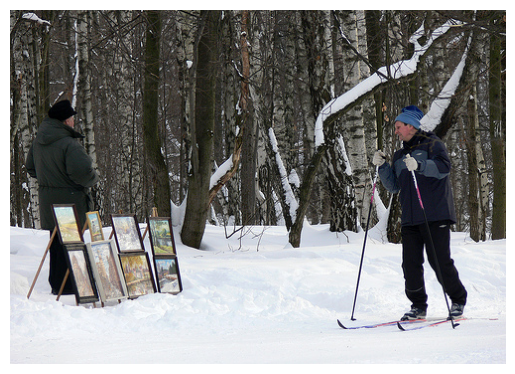


---------------------Actual Captions---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq

--------------------Predicted Caption--------------------
Man in hat is displaying pictures next to skier in blue hat.




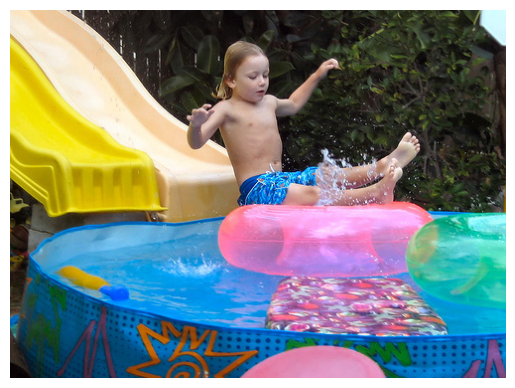


---------------------Actual Captions---------------------
startseq boy in blue shorts slides down slide into pool endseq
startseq boy in blue swimming trunks slides down yellow slide into wading pool with inflatable toys floating in the water endseq
startseq boy rides down slide into small backyard pool endseq
startseq boy sliding down slide into pool with colorful tubes endseq
startseq child is falling off slide onto colored balloons floating on pool of water endseq

--------------------Predicted Caption--------------------
Boy rides down slide into small backyard pool.




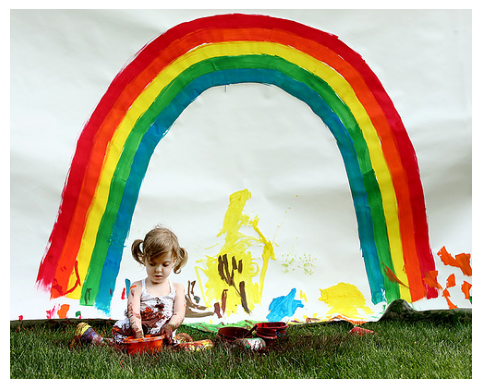


---------------------Actual Captions---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq

--------------------Predicted Caption--------------------
Little girl in the grass plays with fingerpaints in front of white canvas with rainbow on it.




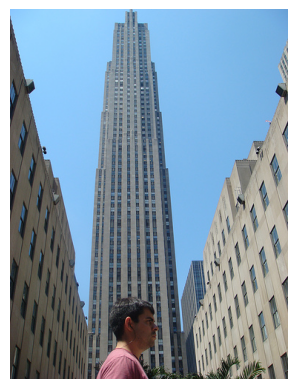


---------------------Actual Captions---------------------
startseq man is standing in front of skyscraper endseq
startseq man stands in front of skyscraper endseq
startseq man stands in front of very tall building endseq
startseq behind the man in red shirt stands large skyscraper endseq
startseq there is skyscraper in the distance with man walking in front of the camera endseq

--------------------Predicted Caption--------------------
Man stands in front of skyscraper.




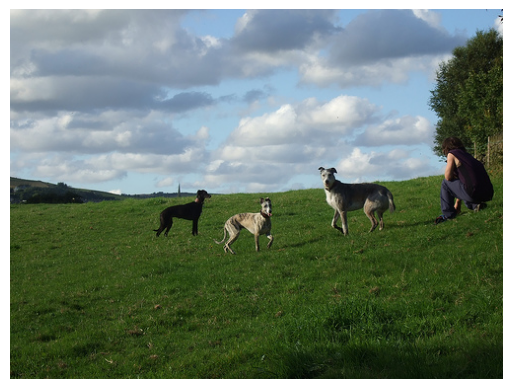


---------------------Actual Captions---------------------
startseq woman crouches near three dogs in field endseq
startseq three dogs are playing on grassy hill with blue sky endseq
startseq three dogs are standing in the grass and person is sitting next to them endseq
startseq three dogs on grassy hill endseq
startseq three dogs stand in grassy field while person kneels nearby endseq

--------------------Predicted Caption--------------------
Three dogs stand in grassy field while person kneels nearby.




In [ ]:
image_paths = [
    "/content/flickr/Images/101669240_b2d3e7f17b.jpg",
    "/content/flickr/Images/1077546505_a4f6c4daa9.jpg",
    "/content/flickr/Images/1002674143_1b742ab4b8.jpg",
    "/content/flickr/Images/1032460886_4a598ed535.jpg",
    "/content/flickr/Images/1032122270_ea6f0beedb.jpg"
]

beam_width = 5

for image_path in image_paths:
    generate_caption_with_beam_search(image_path, beam_width=beam_width)

##Predicting Captions for an Images

In [24]:
def predict_caption(model, image_features, tokenizer, max_caption_length):
    caption = 'startseq'

    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length)
        yhat = model.predict([image_features, sequence], verbose=0)
        predicted_index = np.argmax(yhat)

        predicted_word = get_word_from_index(predicted_index, tokenizer)
        caption += " " + predicted_word

        if predicted_word is None or predicted_word == 'endseq':
            break

    return caption

def preprocess_image(image):
    image = image.resize((299, 299))
    image = np.array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    return image

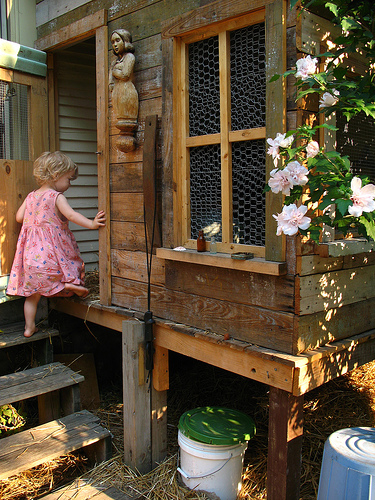


--------------------Predicted Caption--------------------
Little girl in pink dress going into wooden cabin.


In [ ]:
image_path = "/content/cb83b6dd-3e2c-48ae-80fc-12f7c3afbed4.jpg"
image = Image.open(image_path)
display(image)

image = preprocess_image(image)
base_model = Xception(include_top=True, weights='imagenet')
base_model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
features= base_model.predict(image, verbose=0)

predicted_caption = predict_caption(captioning_model, features, tokenizer, max_sequence_length)
predicted_caption = (predicted_caption.replace('startseq', '').replace('endseq', '').strip()).capitalize()+ '.'

print('\n--------------------Predicted Caption--------------------')
print(predicted_caption)

##Evaluating Image Captioning Model Using BLEU Score

In [ ]:
actual_captions_list = []
predicted_captions_list = []

for key in tqdm(testing_set):
    actual_captions = image_to_captions_mapping[key]
    predicted_caption = predict_caption(captioning_model, image_features[key], tokenizer, max_sequence_length)

    actual_captions_words = [caption.split() for caption in actual_captions]
    predicted_caption_words = predicted_caption.split()

    actual_captions_list.append(actual_captions_words)
    predicted_captions_list.append(predicted_caption_words)

print("BLEU-1: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.514265
BLEU-2: 0.253775
